In [1]:
!nvidia-smi

Fri Oct 31 16:06:28 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 16%   26C    P8                2W / 250W|     18MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

import sys
#sys.path.append("../../")
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
#os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,6,7'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", False)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_156092/317505123.py:15: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
import diffhydro as dh


eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[256,256,256]

In [4]:
U = dh.turbulence.init_turbulent_velocity(eq, 100, .10, 10.0,kmax=10,target_M=1.0,pslope=-1.5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


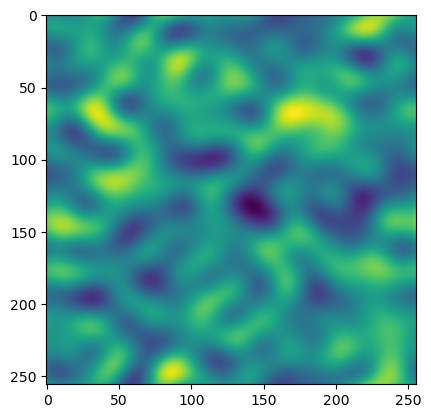

In [5]:
%pylab inline
imshow(U[3][30])

In [6]:
dh.NoBoundary.impose?

Signature: dh.NoBoundary.impose(self, sol, axis, width=1)
Docstring: No boundary conditions applied.
File:      ~/DiffHydro_public/diffhydro/boundary/boundary.py
Type:      function

In [7]:
ss = dh.signal_speed_Rusanov

solver = dh.HLLC(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=True)
#ct = dh.mhd.ConstrainedTransportFlux(eq, solver, dh.MUSCL3(limiter="MINMOD"), positivity=False)

hydro = dh.hydro(n_super_step=100, fluxes=[cf],forces=[],
                 use_mol=True, 
                 use_ctu=False, 
                 integrator="SSPRK3",
                 pmesh_shape=(2,2,1),maxjit=True,
                boundary = dh.NoBoundary) 




In [8]:
params = {}
output_first = hydro.evolve(U,params)

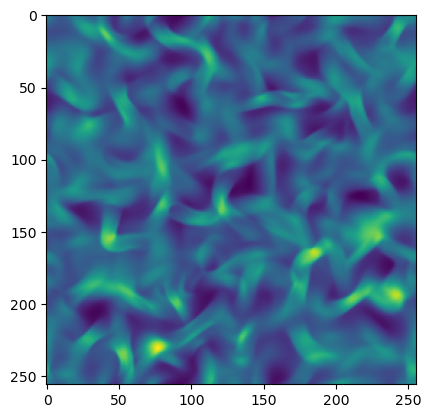

In [9]:

imshow(output_first[0][0][30])

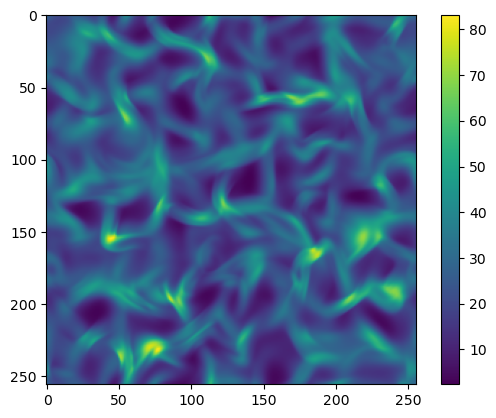

In [10]:
imshow(output_first[0][-1][30])
colorbar()

In [11]:
from diffhydro.prob_gen import make_gaussian_blob

init_sol,_ = make_gaussian_blob(eq, eq.mesh_shape)


In [12]:
inject = (init_sol[-1]-init_sol[-1,0,0,0])

In [13]:
pre_inject = output_first[0]

In [14]:
pre_inject = pre_inject.at[-1].add(inject*100000)

In [15]:
prim = eq.get_primitives_from_conservatives(pre_inject)
eq.get_temperature(prim[-1],prim[0]).max() #supernovas are hot!

Array(9201408., dtype=float32)

In [26]:
hydrosim = dh.hydro(n_super_step=1000, fluxes=[cf],forces=[],
                 use_mol=True, 
                 use_ctu=False, 
                 integrator="SSPRK3",
                 pmesh_shape=(4,1,1),
                 maxjit=True,
#                 boundary= dh.NoBoundary,
                snapshot_dir = "snapshots_nocool",
                 snapshot_every= 100
                ) 

In [17]:


output = hydrosim.evolve_with_callbacks(pre_inject,params)

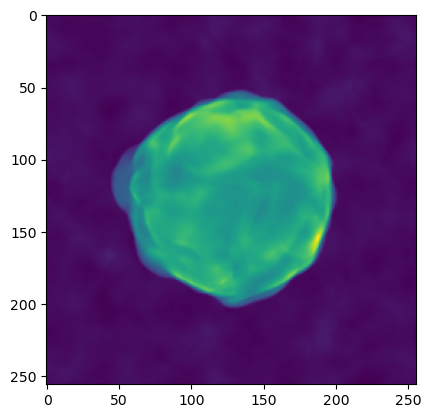

In [27]:
imshow(output[0][-1].sum(axis=0))

In [19]:
from diffhydro.utils.io import shard_snaps


In [20]:
shard_snaps.load_snapshot

<function diffhydro.utils.io.shard_snaps.load_snapshot(hydrosim, step_i, snapshot_dir=None)>

Shard shape: (5, 64, 256, 256)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


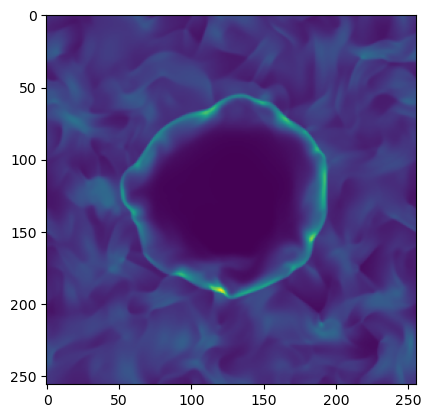

In [52]:
imshow(shard_snaps.load_snapshot(hydrosim,900)[0][128])

In [34]:
cooling_table = np.genfromtxt("../../data/m-00.cie")
logT, logLambda_m20 = cooling_table[:,0],cooling_table[:,1]

def pressure_from_manager(eq, U):
    W = eq.get_primitives_from_conservatives(U)
    return jnp.maximum(W[eq.energy_ids], eq.eps)

cool_v1 = dh.cooling.HeatCoolForce(
    equation_manager=eq,
    pressure_fn=lambda U: pressure_from_manager(eq, U),
    logT_table=logT,
    logLambda_m20_table=logLambda_m20,
    include_heating=True,
    early_exit= True,
    ctime= 0.3,
    dtmax= 1E10,
    temp_floor=50.0
)

In [42]:

eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[256,256,256]

ss = dh.signal_speed_Rusanov

solver = dh.HLLC(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=True)

hydrosim_cool = dh.hydro(n_super_step=int(10000),
                    fluxes=[cf], 
                    forces=[cool_v1],
                    use_mol=True,
                    integrator="SSPRK3",
                    pmesh_shape=(4,1,1),
                    snapshot_dir = "snapshots_cool_v2",
                    snapshot_every= 250,
                    maxjit=True)

In [ ]:
output_cool = hydrosim_cool.evolve_with_callbacks(pre_inject,params)

Shard shape: (5, 64, 256, 256)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


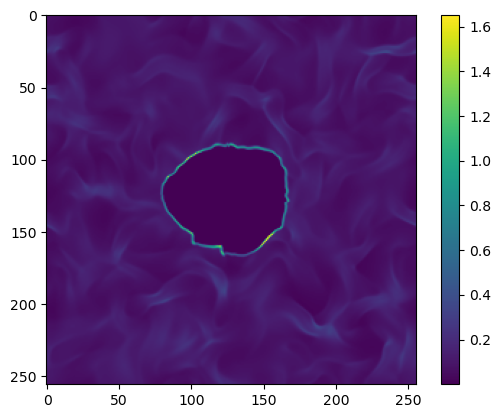

Shard shape: (5, 64, 256, 256)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


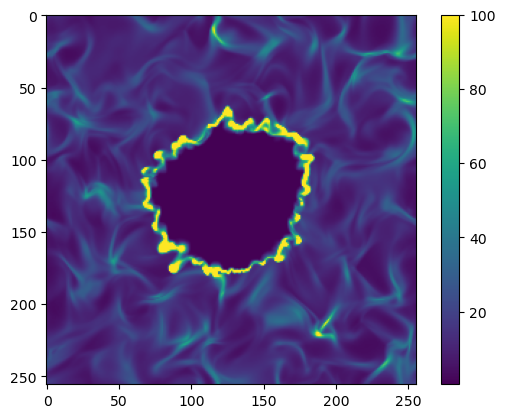

In [63]:
imshow(shard_snaps.load_snapshot(hydrosim_cool,4750)[0][128])
colorbar()
show()
imshow(shard_snaps.load_snapshot(hydrosim_cool,6000)[-1][128],vmax=100)
colorbar()
show()

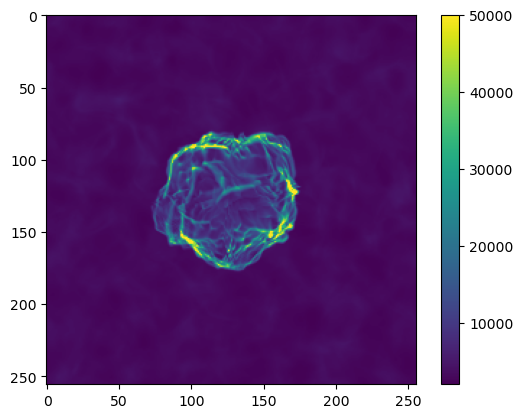

In [153]:
imshow(output_cool3[0][-1].sum(axis=1),vmax=50000)
colorbar()
show()

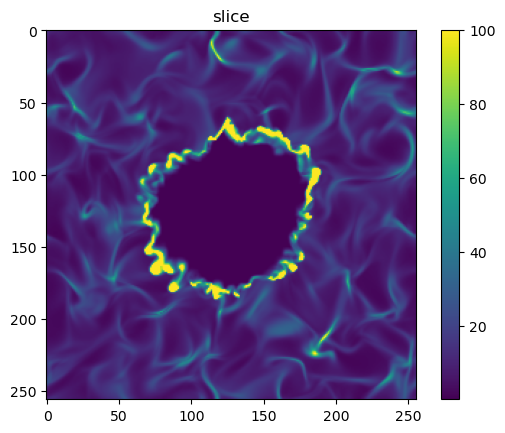

In [168]:
imshow(output_cool4[0][-1][126],vmax=100)
colorbar()
title("slice")
show()

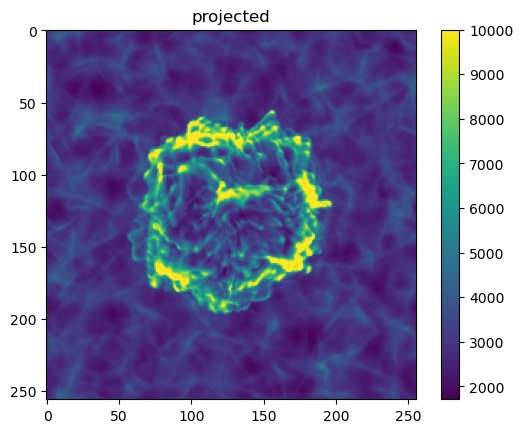

In [166]:
imshow(output_cool4[0][-1].sum(axis=1),vmax=10000)
colorbar()
title("projected")
show()

In [189]:
##Some playing around with modelling photometry, nothing very good...

In [77]:

U = shard_snaps.load_snapshot(hydrosim_cool,6000)
# get primitives once
W = eq.get_primitives_from_conservatives(U)                  # repo idiom
# e.g. density, pressure, temperature
rho = W[eq.mass_ids]
p   = W[eq.energy_ids]
T   = eq.get_temperature(p, rho)                             # repo helper

# simple choices for j and alpha
# line emissivity ~ n_e n_H Λ(T): use rho^2 times a tabulated Λ(T) if you have it
j = (rho**2) * 10**cool_v1._interp_logLambda_m20(np.log10(T))                                   # shape (nx, ny, nz)
 

Shard shape: (5, 64, 256, 256)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


In [78]:

# absorption: pick a model (e.g., dust or self-absorption); simplest: alpha = kappa * rho
alpha = 0.01 * rho                                          # same shape

ds = 1.0  
tau = np.cumsum(alpha * ds, axis=0)                          # cumulative *after* each layer
tau_prev = tau - alpha*ds                                    # optical depth before voxel k
trans = np.exp(-np.clip(tau_prev, 0, 1e3))
I = np.sum(j * trans * ds, axis=0)    

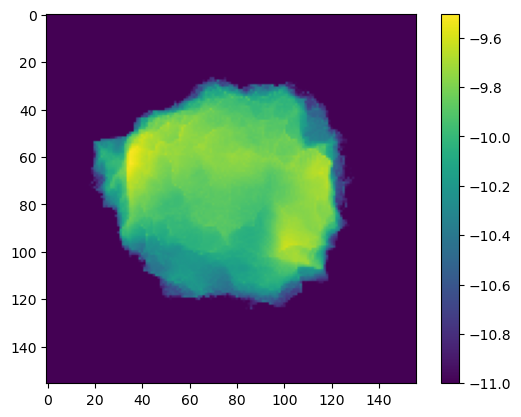

In [80]:
imshow(np.log10(I[50:-50,50:-50]),vmin=-11)
colorbar()
show()

In [291]:
#Not quite sold on it...

In [154]:
import jax
import jax.numpy as jnp
from jax.scipy.signal import convolve 
from jax.scipy.signal import fftconvolve  

# basic plasma bookkeeping (toy constants) ----
m_p = 1.6726219e-24  # g
kB_keV_per_K = 8.617333262e-8  # keV/K

# Assume a fully ionized H/He plasma with mean molecular weights:
# tune mu, mu_e as needed (these are common cluster-ish values)
mu    = 0.59     # mean mass per particle in units of m_p
mu_e  = 1.17     # mean mass per electron in units of m_p
mu_H  = 1.40     # mass per H nucleus in units of m_p (for n_H ~ rho/(mu_H m_p))

def n_e_n_H_from_rho(rho):
    n_e = rho/(mu_e*m_p)  # electrons / cm^3  (if rho is g/cm^3)
    n_H = rho/(mu_H*m_p)  # H nuclei / cm^3
    return n_e, n_H

# ---- Band-limited free-free emissivity (toy) ----
def Lambda_ff_band(T, E1_keV, E2_keV, gB=1.2, Z2bar=1.0):
    """
    Very crude band-integrated thermal bremsstrahlung cooling function.
    Units here are "up to a constant"; good for morphology/relative maps.
    For absolute calibration, replace with APEC/MEKAL band emissivities.
    """
    kT = kB_keV_per_K * T              # keV
    # Prefactor ~ sqrt(T) * Gaunt * Z^2; (constant overall scale omitted)
    pref = jnp.sqrt(jnp.maximum(T, 1e-10)) * gB * Z2bar
    # Integrate exp(-E/kT) dE over band: kT * (e^{-E1/kT} - e^{-E2/kT})
    band_int = kT * (jnp.exp(-E1_keV/jnp.maximum(kT, 1e-12))
                   - jnp.exp(-E2_keV/jnp.maximum(kT, 1e-12)))
    return pref * band_int  # "arb" units

def emissivity_band(rho, T, E1_keV=0.5, E2_keV=2.0):
    n_e, n_H = n_e_n_H_from_rho(rho)
    Lambda = Lambda_ff_band(T, E1_keV, E2_keV)
    return 10**(np.log10(n_e)+np.log10(n_H) + np.log10(Lambda))#avoiding some nans maybe  # ε ∝ erg cm^-3 s^-1 (up to constant scale)

# ---- Axis-aligned projection with optional absorption ----
def project_intensity(eps, dl_cm, N_H_foreground=0.0, Eeff_keV=1.0, sigma0=3e-22):
    """
    eps: emissivity [*, nz] or [nx, ny, nz]
    dl_cm: path length per cell (cm)
    N_H_foreground: foreground column (cm^-2), simple screen model
    Eeff_keV: effective energy for band-averaged absorption
    sigma0: ~3e-22 cm^2 at 1 keV with ~E^-3 law (very crude)
    """
    I = jnp.sum(eps * dl_cm, axis=-1) / (4.0*jnp.pi)
    # foreground screen (band-averaged)
    sigma = sigma0 * (Eeff_keV / 1.0)**(-3.0)
    return I * jnp.exp(-sigma * N_H_foreground)

# ---- Optional PSF + counts + Poisson noise ----
def apply_psf_counts(I, psf_kernel=None, eff_area_cm2=400.0, exposure_s=10000.0, key=None):
    # Convolve with a small PSF kernel if provided (normalize kernel sum to 1)
    if psf_kernel is not None:
        psf_kernel = psf_kernel / jnp.sum(psf_kernel)
        # Use 2D convolution (valid for small, separable-ish PSFs)
        I = fftconvolve(I, psf_kernel, mode='same')  # <- FFT-based, no cuDNN
    # Convert intensity (arb) to expected counts with a global scalar
    # For a real pipeline, insert: instrument effective area vs energy + pixel solid angle.
    lam = I * eff_area_cm2 * exposure_s
    if key is None:
        key = jax.random.PRNGKey(0)
    counts = jax.random.poisson(key, lam)
    return counts

In [180]:
rho = W[0]
T   = eq.get_temperature(W[-1], W[0])  # see your example notebooks
# eps has shape [nx, ny, nz] if you project along z:
eps = emissivity_band(rho.astype(jnp.float64)/10.0**30, T.astype(jnp.float64)*10**1, E1_keV=0.5, E2_keV=2.0)


/tmp/ipykernel_156092/4103635089.py:39: RuntimeWarning: divide by zero encountered in log10
  return 10**(np.log10(n_e)+np.log10(n_H) + np.log10(Lambda))#avoiding some nans maybe  # ε ∝ erg cm^-3 s^-1 (up to constant scale)


In [181]:

dz_cm = 10**20 / 256  # something like 10 parsec / 256 box
I = project_intensity(eps, dz_cm, N_H_foreground=3e20, Eeff_keV=1.0)  # e.g. soft band

# Simple Gaussian PSF kernel (optional)
def gaussian_kernel(size=9, sigma_pix=1.5):
    ax = jnp.arange(size) - (size-1)/2
    xx, yy = jnp.meshgrid(ax, ax, indexing='ij')
    K = jnp.exp(-(xx**2 + yy**2)/(2*sigma_pix**2))
    return K

key = jax.random.PRNGKey(42)
psf = gaussian_kernel( nine:=9, sigma_pix=1.2 )
counts = apply_psf_counts(I, psf_kernel=psf, eff_area_cm2=400., exposure_s=2e4, key=key)

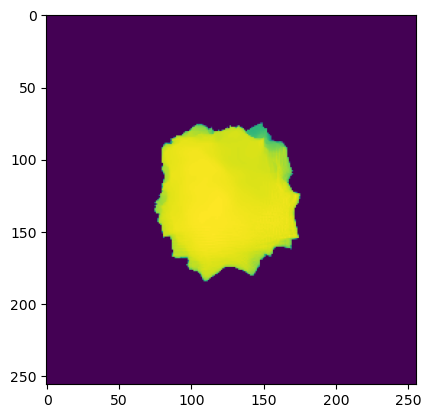

In [188]:
imshow(np.log10(I+10**-32))